In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import gsw
import glob, os
import float_data_processing as fl
import carbon_utils
from scipy import interpolate
import matplotlib.dates as mdates
# import statsmodels.api as sm
import scipy.stats as stats



In [3]:
# Set the paths
output_dir = 'output/'
data_dir = 'data/'

#check directories exist
if not os.path.isdir('output'):
    os.mkdir('output')
if not os.path.isdir('data'):
    os.mkdir('data')

# Check for a glodap_offsets_plots directory, create if it does not exist
offset_dir = output_dir + 'glodap_offset_plots/'
if not os.path.isdir(offset_dir):
    os.mkdir(offset_dir)

# +
# read in a user-created text file to point to local directories to avoid having to change this every time 
# we update code
lines=[]
with open('path_file.txt') as f:
    lines = f.readlines()
    
count = 0
for line in lines:
    count += 1
    index = line.find("=")
    #print(f'line {count}: {line}')
    #print(index)
    #print(line[0:index])
    line = line.rstrip()
    if line[0:index].find("argo")>=0:
        argo_path=line[index+1:]
    elif line[0:index].find("liar")>=0:
        liar_dir=line[index+1:]
    elif line[0:index].find("matlab")>=0:
        matlab_dir=line[index+1:]

#add derived float file directory within argo_path
argo_path_derived = argo_path+'derived/'
if not os.path.isdir(argo_path_derived):
    os.mkdir(argo_path_derived)

# Set the paths
output_dir = 'output/'
data_dir = 'data/'
output_dir_figs = 'figures_o2_bias/'
argo_path_derived = argo_path+'../derived/'
#check directories exist
if not os.path.isdir('figures_o2_bias'):
    os.mkdir('figures_o2_bias')

In [9]:
def regress_confidence_sokal_rohlf(X, Y, alpha):

    q = 1-alpha
    # calculate averages
    X_bar = np.mean(X)
    Y_bar = np.mean(Y)

    #difference of datapoints from mean
    x_small = X - X_bar
    y_small = Y - Y_bar

    # sum of the square differences in x
    sum_x2 = np.nansum(np.square(x_small))

    # multiple differences from mean to get xy and sum
    xy = x_small*y_small
    sum_xy = np.nansum(xy)

    # regression coefficient (slope of the regression)
    b_yx = sum_xy/sum_x2

    # y intercept 
    a = Y_bar - b_yx*X_bar

    # predicted Y based on regression
    Y_hat = b_yx*X + a

    # unexplained sum of squares
    d2_yx = np.sum(np.square(Y-Y_hat))

    # explained variance:
    s2_y_hat = np.sum(np.square(Y_hat - Y_bar))/(len(Y)-1)

    # unexplained variance:
    dof = (len(Y) - 2)
    s2_yx = d2_yx/dof;

    # total variance:
    s2_Y = np.sum(np.square(Y - Y_bar))/(len(Y)-1)

    # coefficient of determination (r2)
    r2 = s2_y_hat/s2_Y

    # standard error of the regression coefficient
    sb = np.sqrt(s2_yx/sum_x2);

    # regression coefficient (slope) different than zero?
    t_s = (b_yx - 0)/sb

    # t stat
    t_stat = stats.t.ppf(1-q/2, dof)

    CI_alpha_slope = [b_yx - t_stat*sb, b_yx + t_stat*sb]

    # standard error of Y_hat for a given value of X (every value)
    sy_hat = (s2_yx*(1/len(Y) + ((X-X_bar)**2)/sum_x2))**0.5

    # upper confidence interval
    y_err = t_stat*sy_hat

    return b_yx, a, r2, CI_alpha_slope, t_stat*sb/2, y_err

In [4]:
gdap = fl.get_glodap(data_dir, year = 2022)
gdap.G2longitude[gdap.G2longitude < 0.] = gdap.G2longitude[gdap.G2longitude < 0.] + 360.
#set flagged data to NaN (is this needed? or masked array better?)
flagvars = ['G2salinity','G2oxygen','G2nitrate','G2tco2','G2talk','G2phts25p0']

for v in flagvars:
    flag = v+'f'
    naninds = gdap[flag]!=2
    gdap[v][naninds] = np.nan
# -


# GLODAP derived variables: density, MLD and pH

#calc potential density
gdap['sigma0_calculated'] = carbon_utils.sigma0(gdap.G2salinity.values,gdap.G2temperature.values,
                                  gdap.G2longitude.values,gdap.G2latitude.values,gdap.G2pressure.values)
#calculate spice
gdap['spice'] = carbon_utils.spiciness0(gdap.G2salinity.values,gdap.G2temperature.values,
                                  gdap.G2longitude.values,gdap.G2latitude.values,gdap.G2pressure.values)


https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0257247/GLODAPv2.2022_Merged_Master_File.csv


/Users/smb-uh/UHM_Ocean_BGC_Group Dropbox/Seth Bushinsky/Work/Manuscripts/2022_07 Deep O2 Bias/argo_deep_o2_bias/float_data_processing.py:36: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gdap = pd.read_csv(save_dir+'GLODAPv2.'+str(year)+'_Merged_Master_File.csv')
<ipython-input-4-7c56a9571938>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdap.G2longitude[gdap.G2longitude < 0.] = gdap.G2longitude[gdap.G2longitude < 0.] + 360.
<ipython-input-4-7c56a9571938>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdap[v][naninds] = np.nan
/Users/smb-uh/miniconda3/envs/

In [5]:

for v in flagvars:
    flag = v+'f'
    naninds = gdap[flag]!=2
    gdap[v][naninds] = np.nan
# -

#rename GLODAP comparison variables to match argo
gdap = gdap.rename(columns={'G2longitude':'LONGITUDE', 'G2latitude':'LATITUDE', 'G2pressure':'PRES_ADJUSTED',
                            'G2temperature':'TEMP_ADJUSTED','G2salinity':'PSAL_ADJUSTED', 
                            'G2oxygen':'DOXY_ADJUSTED','G2nitrate':'NITRATE_ADJUSTED', 'G2tco2':'DIC', 
                            'G2talk':'TALK_LIAR', 'G2MLD':'MLD','G2o2sat':'o2sat', 'G2PTMP':'PTMP', 
                            'pH_in_situ_total':'PH_IN_SITU_TOTAL_ADJUSTED','sigma0_calculated':'PDENS'})


<ipython-input-5-fb8b1d97f292>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdap[v][naninds] = np.nan


In [7]:

#pressure limits for crossover comparison
p_compare_min = 250
p_compare_max = 3000
gdap_p = gdap[(gdap.PRES_ADJUSTED.values>p_compare_min) & (gdap.PRES_ADJUSTED.values<p_compare_max)]


In [29]:
var_list_interp = ['TEMP_ADJUSTED', 'PSAL_ADJUSTED', 'DOXY_ADJUSTED']
plot_on = False

lon_grid = 10
lat_grid = 4
lon_vec = list(range(0, 360 + 1, lon_grid))
lat_vec = list(range(-80, 80 + 1, lat_grid))

min_pressure = 300
max_pressure = 2000

press_interp_range = range(min_pressure, max_pressure,1)

# Initialize an empty list to store data
spatial_info_out = []
target_sigma0_range = range(250, 290, 1)
# target_sigma0_range = range(275, 276, 1)

# loop through grid, find all glodap data in lon x lat grid cell
for lo in range(0, len(lon_vec)-1):
    for la in range(0, len(lat_vec)-1):

        # la = 10
        # lo = 1
        print(str(lon_vec[lo]) + ' ' + str(lat_vec[la]))
        # print(lat_vec[la])


        match = np.logical_and((np.logical_and(np.logical_and(gdap_p.LATITUDE.values>lat_vec[la],
                                                        gdap_p.LATITUDE.values<=lat_vec[la+1]),
                                        np.logical_and(gdap_p.LONGITUDE.values>lon_vec[lo],
                                                        gdap_p.LONGITUDE.values<=lon_vec[lo+1]))),
                                                        ~np.isnan(gdap_p.DOXY_ADJUSTED.values))
        match = np.squeeze(match)
        # print(np.sum(match))
        match_inds = np.argwhere(match)

        #get matched glodap data subset
        #if len(match_inds)==0:
        #    continue

        #get glodap data points that match
        gdap_match = gdap_p[match]
        gdap_match = gdap_match.sort_values(by='datetime', ascending=True)
        # print(len(gdap_match))
        # print(gdap_match.DOXY_ADJUSTED)

        # Initialize an empty list to store data
        oxygen_density_out = []

        #print(gdap_match.G2cruise)
        gdap_match_cruise = np.unique(gdap_match.G2cruise)
        for cruise_index, cr in enumerate(gdap_match_cruise):
            # print(cr)
            gdap_cruise = gdap_match[gdap_match.G2cruise==gdap_match_cruise[cruise_index]]
            # print(gdap_cruise['G2year'])
            #print(len(gdap_cruise))
            #print(gdap_cruise)

            #gdap_cruise = gdap_match.groupby('G2cruise')

            station_list = np.unique(gdap_cruise.G2station)
            for idx, st in enumerate(station_list):
                # print(idx)
                # loop through all stations for a given cruise, interpolate data, and find oxygen on target density grid:
                #print(station_list)
                station = gdap_cruise[gdap_cruise.G2station==station_list[idx]]
                if len(station)<2:
                    continue
                # print(station['G2year'])

                # print(station.G2year)
                # = gdap_match.where(gdap_match.G2cruise==gdap_match_cruise[0], gdap_match)
                #print(cruise)
                var_interp_dict = {}
                for var in var_list_interp:
                    # create an interpolated dataset, then find and save values at certain density levels
                    f = interpolate.interp1d(station.PRES_ADJUSTED, station[var], fill_value=np.nan, bounds_error=False)

                    var_interp_dict[var] = f(press_interp_range)
                # for key in var_interp_dict:
                #     print(key, var_interp_dict[key])  # Accessing both key and value
                # var_interp_dict['TEMP_ADJUSTED']

                #calc potential density
                sigma0_station = carbon_utils.sigma0(var_interp_dict['PSAL_ADJUSTED'],var_interp_dict['TEMP_ADJUSTED'],
                                                station.LONGITUDE.values[0], station.LATITUDE.values[0], press_interp_range)
                #calculate spice
                if np.sum(~np.isnan(sigma0_station))==0:
                    continue
                spice0_station = carbon_utils.spiciness0(var_interp_dict['PSAL_ADJUSTED'],var_interp_dict['TEMP_ADJUSTED'],
                                                station.LONGITUDE.values[0], station.LATITUDE.values[0], press_interp_range)
                # print(sigma0_station)

                for dens in target_sigma0_range:

                    target_sigma0 = dens/10
                    # Calculate the absolute differences between DOXY_ADJUSTED and the target value
                    abs_differences = np.abs(sigma0_station - target_sigma0)

                    # Find the index of the closest value
                    closest_index = np.nanargmin(abs_differences)

                    # check if the closest density is less than 0.001 away
                    if np.abs(sigma0_station[closest_index] - target_sigma0)< 0.001:
                        # Get the closest value of DOXY_ADJUSTED
                        doxy_matched = var_interp_dict['DOXY_ADJUSTED'][closest_index]
                        sigma0_matched = sigma0_station[closest_index]
                        spice0_matched = spice0_station[closest_index]
                        press_matched = press_interp_range[closest_index]
                        oxygen_density_out.append({'PDENS': sigma0_matched, 'datetime': station.datetime.values[0], 'PRES_ADJUSTED': press_matched, 'LATITUDE': station.LATITUDE.values[0], 
                                                'LONGITUDE': station.LONGITUDE.values[0], 'DOXY_ADJUSTED': doxy_matched, 'spice': spice0_matched})
                    # else:
                    #     print(sigma0_station[closest_index])
                    #     print(target_sigma0)


        # convert to dataframe
        oxygen_density_out = pd.DataFrame(oxygen_density_out)
        if len(oxygen_density_out)==0:
            continue
        oxygen_density_out = oxygen_density_out.sort_values(by='datetime', ascending=True)

        # print(oxygen_density_out)
        # for each lat/lon grid cell, I want the option to plot all available glodap data in the pressure range, plus the interpolated values
        plot_vars = ['LATITUDE', 'LONGITUDE', 'PRES_ADJUSTED', 'PDENS', 'spice', 'DOXY_ADJUSTED']
        spice_range = 0.01
        CI_alpha = 0.95

        # row_p = np.int32(np.ceil(len(plot_vars)/2))
        fig = plt.figure(figsize=(16,16))

        for d_idx, dens in target_sigma0_range:
            # print(dens)

            target_sigma0 = dens/10

            spice_filt = oxygen_density_out['spice'][(oxygen_density_out['PDENS']>target_sigma0-.01) & (oxygen_density_out['PDENS']<target_sigma0+.01)&  
                                                                (oxygen_density_out['PRES_ADJUSTED']<max_pressure)  &  (oxygen_density_out['PRES_ADJUSTED']>min_pressure)]
            
            # if no spice values are found (probably because no data exist at that density) then continue without plotting 
            if len(spice_filt)==0:
                continue

            spice_mean = np.mean(spice_filt)

            if plot_on:
                gdap_all_date = gdap_match['datetime'][(gdap_match['PRES_ADJUSTED']>min_pressure) & (gdap_match['PRES_ADJUSTED']<max_pressure)]


                for idx, var in enumerate(['PRES_ADJUSTED', 'DOXY_ADJUSTED']): #enumerate(plot_vars):
                    axn = plt.subplot(row_p,2,idx+1)
                    plt.title(var)
                    # print(var)
                    gdap_all_var = gdap_match[var][(gdap_match['PRES_ADJUSTED']>min_pressure) & (gdap_match['PRES_ADJUSTED']<max_pressure)]

                    plt.plot(gdap_all_date, gdap_all_var, marker='x', linestyle='none', markersize=10, color='blue')
                    
                    X_series = pd.Series(mdates.date2num(gdap_all_date))
                    Y_series = pd.Series(gdap_all_var.values)
                    # model = sm.OLS(Y_series, sm.add_constant(X_series)).fit()
                    # intercept, slope = model.params

                    # conf_int = model.conf_int(alpha=0.05)

                    b_yx, a, r2, CI_alpha_slope, ttt, y_err = regress_confidence_sokal_rohlf(X_series, Y_series, CI_alpha)

                    y_est = a+ X_series*b_yx
                    plt.plot(X_series, y_est, color='blue', label='Regression Line')
                    plt.fill_between(X_series, y_est-y_err, y_est+y_err, color='blue', alpha=0.5, label='Confidence Interval')    
                    
                    gdap_filter_date = oxygen_density_out['datetime'][(oxygen_density_out['PDENS']>target_sigma0-.01) & (oxygen_density_out['PDENS']<target_sigma0+.01) &  
                                                                    (oxygen_density_out['PRES_ADJUSTED']<max_pressure)  &  (oxygen_density_out['PRES_ADJUSTED']>min_pressure) &
                                                                    (oxygen_density_out['spice']>spice_mean - spice_range)  &  (oxygen_density_out['spice']<spice_mean + spice_range)]
                    gdap_filter_var = oxygen_density_out[var][(oxygen_density_out['PDENS']>target_sigma0-.01) & (oxygen_density_out['PDENS']<target_sigma0+.01)&  
                                                                    (oxygen_density_out['PRES_ADJUSTED']<max_pressure)  &  (oxygen_density_out['PRES_ADJUSTED']>min_pressure)&
                                                                    (oxygen_density_out['spice']>spice_mean - spice_range)  &  (oxygen_density_out['spice']<spice_mean + spice_range)]

                    plt.plot(gdap_filter_date, gdap_filter_var.values, marker='s', linestyle='none', color='orange')

                    if len(gdap_filter_date)>2:
                        # calculate and plot regression
                        X2_series = pd.Series(mdates.date2num(gdap_filter_date))
                        Y2_series = pd.Series(gdap_filter_var.values)

                        b_yx2, a2, r2, CI_alpha_slope, ttt, y_err2 = regress_confidence_sokal_rohlf(X2_series, Y2_series, CI_alpha)

                        y_est2 = a2+ X2_series*b_yx2

                        o2_rate_change = b_yx2*365
                        o2_rate_CI = np.multiply(CI_alpha_slope, 365)

                        plt.plot(X2_series, y_est2, color='orange', label='Slope: ' + str(o2_rate_change.round(decimals=2)) + ' umol/kg/yr ' + 'CI: ' + str(o2_rate_CI.round(decimals=2)))
                        plt.fill_between(X2_series, y_est2-y_err2, y_est2+y_err2, color='orange', alpha=0.5, label= str(CI_alpha) +' Confidence Interval')    
                        
                        if var=='DOXY_ADJUSTED':
                            plt.legend()
                fig.suptitle('Lon: ' + str(lon_vec[lo]) + ' Lat: ' + str(lat_vec[la]) + ' PDENS: ' + str(target_sigma0))
                plt.tight_layout()

                # plt.show()
                plt.savefig(output_dir_figs + plot_filename + '_' + str(min_pressure) + '_' + str(max_pressure) + '.png', dpi=300)

            gdap_filter_date = oxygen_density_out['datetime'][(oxygen_density_out['PDENS']>target_sigma0-.01) & (oxygen_density_out['PDENS']<target_sigma0+.01) &  
                                                                (oxygen_density_out['PRES_ADJUSTED']<max_pressure)  &  (oxygen_density_out['PRES_ADJUSTED']>min_pressure) &
                                                                (oxygen_density_out['spice']>spice_mean - spice_range)  &  (oxygen_density_out['spice']<spice_mean + spice_range)]
            
            if np.logical_or(len(gdap_filter_date)<3, len(gdap_filter_date.dt.year.unique())==1):
                continue

            gdap_filter_oxy = oxygen_density_out['DOXY_ADJUSTED'][(oxygen_density_out['PDENS']>target_sigma0-.01) & (oxygen_density_out['PDENS']<target_sigma0+.01)&  
                                                                (oxygen_density_out['PRES_ADJUSTED']<max_pressure)  &  (oxygen_density_out['PRES_ADJUSTED']>min_pressure)&
                                                                (oxygen_density_out['spice']>spice_mean - spice_range)  &  (oxygen_density_out['spice']<spice_mean + spice_range)]
            
            gdap_filter_press = oxygen_density_out['PRES_ADJUSTED'][(oxygen_density_out['PDENS']>target_sigma0-.01) & (oxygen_density_out['PDENS']<target_sigma0+.01)&  
                                                                (oxygen_density_out['PRES_ADJUSTED']<max_pressure)  &  (oxygen_density_out['PRES_ADJUSTED']>min_pressure)&
                                                                (oxygen_density_out['spice']>spice_mean - spice_range)  &  (oxygen_density_out['spice']<spice_mean + spice_range)]
            
            X2_series = pd.Series(mdates.date2num(gdap_filter_date))
            Y2_series = pd.Series(gdap_filter_oxy.values)

            b_yx2, a2, r2, CI_alpha_slope, ttt, y_err2 = regress_confidence_sokal_rohlf(X2_series, Y2_series, CI_alpha)
            o2_rate_change = b_yx2*365
            o2_rate_CI = np.multiply(CI_alpha_slope, 365)
            
            # calculate oxygen trend, save out information for 
            spatial_info_out.append({'LONGITUDE': lon_vec[lo], 'LATITUDE': lat_vec[la], 'PDENS': target_sigma0, 'Earliest Date': np.min(gdap_filter_date), 'Latest Date': np.max(gdap_filter_date),
                                    'Num unique years': len(gdap_filter_date.dt.year.unique()), 'PRES_ADJUSTED': np.mean(gdap_filter_press) , 'DOXY_ADJUSTED': np.mean(gdap_filter_oxy),
                                    'O2 slope umol kg-1 yr-1': o2_rate_change, str(CI_alpha) + ' CI_slope_lower': o2_rate_CI[0], str(CI_alpha) + ' CI_slope_upper': o2_rate_CI[1]})
                # else:
                #     print(sigma0_station[closest_index])
                #     print(target_sigma0)
        # break
# convert to dataframe
spatial_info_out = pd.DataFrame(spatial_info_out)


0 -80
0 -76
0 -72
0 -68
0 -64
0 -60
0 -56
0 -52
0 -48
0 -44
0 -40
0 -36
0 -32
0 -28
0 -24
0 -20
0 -16
0 -12
0 -8
0 -4
0 0
0 4
0 8
0 12
0 16
0 20
0 24
0 28
0 32
0 36
0 40
0 44
0 48
0 52
0 56
0 60
0 64
0 68
0 72
0 76
10 -80
10 -76
10 -72
10 -68
10 -64
10 -60
10 -56
10 -52
10 -48
10 -44
10 -40
10 -36
10 -32
10 -28
10 -24
10 -20
10 -16
10 -12
10 -8
10 -4
10 0
10 4
10 8
10 12
10 16
10 20
10 24
10 28
10 32
10 36
10 40
10 44
10 48
10 52
10 56
10 60
10 64
10 68
10 72
10 76
20 -80
20 -76
20 -72
20 -68
20 -64
20 -60
20 -56
20 -52
20 -48
20 -44
20 -40
20 -36
20 -32
20 -28
20 -24
20 -20
20 -16
20 -12
20 -8
20 -4
20 0
20 4
20 8
20 12
20 16
20 20
20 24
20 28
20 32
20 36
20 40
20 44
20 48
20 52
20 56
20 60
20 64
20 68
20 72
20 76
30 -80
30 -76
30 -72
30 -68
30 -64
30 -60
30 -56
30 -52
30 -48
30 -44
30 -40
30 -36
30 -32
30 -28
30 -24
30 -20
30 -16
30 -12
30 -8
30 -4
30 0
30 4
30 8
30 12
30 16
30 20
30 24
30 28
30 32
30 36
30 40
30 44
30 48
30 52
30 56
30 60
30 64
30 68
30 72
30 76
40 -80
40 -76
40 -72

In [34]:
plot_vars

['LATITUDE', 'LONGITUDE', 'PRES_ADJUSTED', 'PDENS', 'spice', 'DOXY_ADJUSTED']

In [30]:
np.min(spatial_info_out.PRES_ADJUSTED)

306.7142857142857

In [364]:
sig_slope = np.logical_or(np.logical_and(spatial_info_out['0.95 CI_slope_lower']<0, spatial_info_out['0.95 CI_slope_upper']<0), 
              np.logical_and(spatial_info_out['0.95 CI_slope_lower']>0, spatial_info_out['0.95 CI_slope_upper']>0))


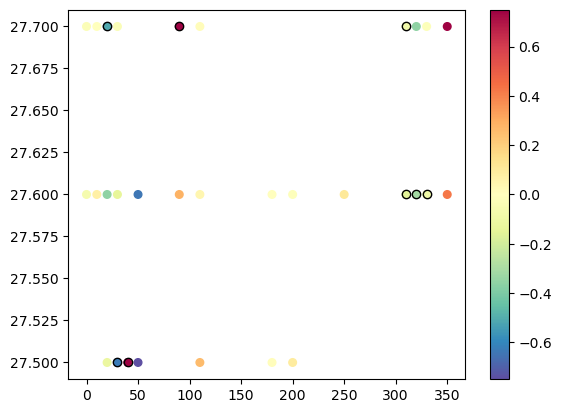

In [367]:
orig_map=plt.cm.get_cmap('Spectral')
  
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

plt.scatter(spatial_info_out['LONGITUDE'], spatial_info_out['PDENS'], 30, spatial_info_out['O2 slope umol kg-1 yr-1'], cmap=reversed_map, vmin=-0.75 , vmax=0.75)
plt.plot(spatial_info_out['LONGITUDE'][sig_slope], spatial_info_out['PDENS'][sig_slope], marker='o', linestyle='none', markerfacecolor='none', color='k')
plt.colorbar()

In [31]:
all_pdens = np.unique(spatial_info_out['PDENS'])
all_pdens

array([25. , 25.1, 25.2, 25.3, 25.4, 25.5, 25.6, 25.7, 25.8, 25.9, 26. ,
       26.1, 26.2, 26.3, 26.4, 26.5, 26.6, 26.7, 26.8, 26.9, 27. , 27.1,
       27.2, 27.3, 27.4, 27.5, 27.6, 27.7, 27.8, 27.9, 28. , 28.6])

<ipython-input-33-63977484b3eb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_lon[temp_lon>180] = temp_lon[temp_lon>180]-360


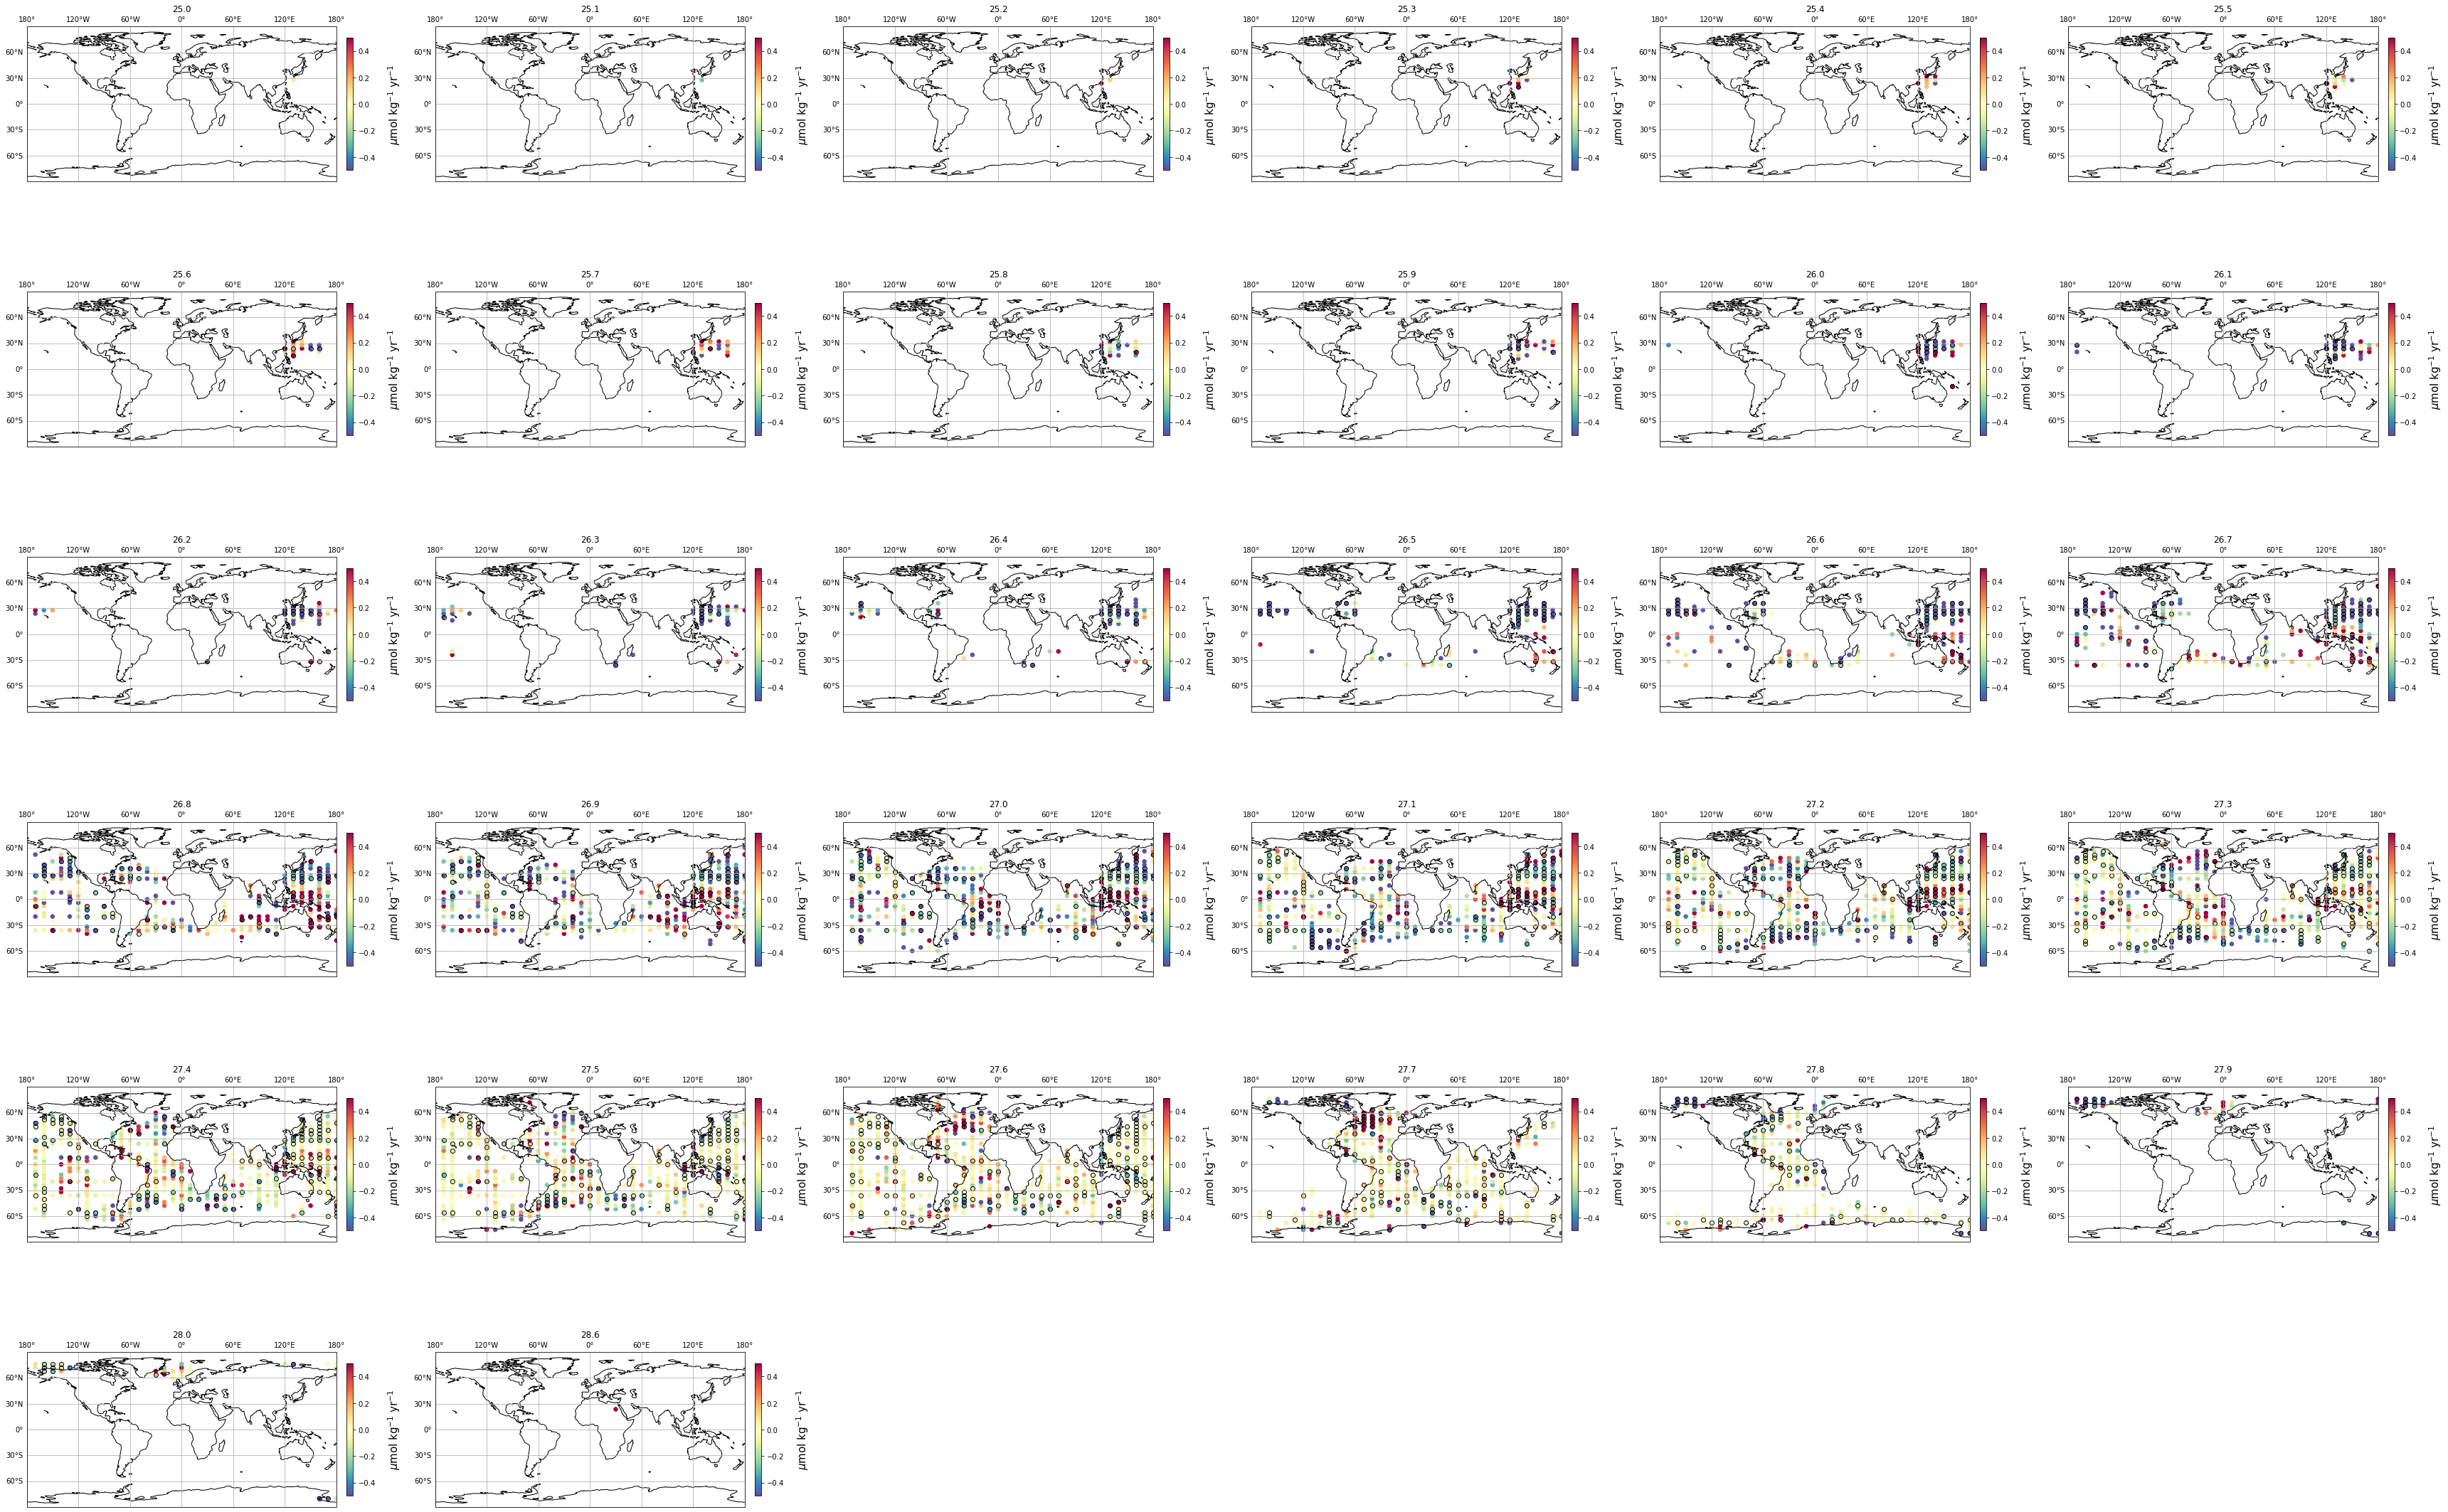

In [33]:
fig = plt.figure(figsize=(60, 40))
orig_map=plt.cm.get_cmap('Spectral')

plot_filename = 'glodap_o2_change'
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()
all_pdens = np.unique(spatial_info_out['PDENS'])

sig_slope = np.logical_or(np.logical_and(spatial_info_out['0.95 CI_slope_lower']<0, spatial_info_out['0.95 CI_slope_upper']<0), 
              np.logical_and(spatial_info_out['0.95 CI_slope_lower']>0, spatial_info_out['0.95 CI_slope_upper']>0))

temp_lon = spatial_info_out['LONGITUDE']
temp_lon[temp_lon>180] = temp_lon[temp_lon>180]-360


for idx, dens in enumerate(all_pdens):
    ax = plt.subplot(6,6,idx+1, projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_global()
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.bottom_labels = False
    map_filt = spatial_info_out['PDENS']==dens
    sct = plt.scatter(temp_lon[map_filt], spatial_info_out['LATITUDE'][map_filt], 30, 
                spatial_info_out['O2 slope umol kg-1 yr-1'][map_filt], cmap=reversed_map, vmin=-0.5 , vmax=0.5)
    cbar = plt.colorbar(sct, fraction=.06, pad = 0.03, shrink=.6)
    cbar.set_label('$\mu$mol kg$^{-1}$ yr$^{-1}$', labelpad=15, fontsize=15)

    sig_slope = np.logical_or(np.logical_and(spatial_info_out['0.95 CI_slope_lower']<0, spatial_info_out['0.95 CI_slope_upper']<0), 
              np.logical_and(spatial_info_out['0.95 CI_slope_lower']>0, spatial_info_out['0.95 CI_slope_upper']>0))
    
    map_filt = np.logical_and(spatial_info_out['PDENS']==dens, sig_slope)


    plt.plot(temp_lon[map_filt], spatial_info_out['LATITUDE'][map_filt], marker='o', linestyle='none', color='k',  markerfacecolor='none')
    plt.title(dens)

plt.savefig(output_dir_figs + plot_filename + '_' + str(min_pressure) + '_' + str(max_pressure) + '.png', dpi=300)



In [406]:
temp_lon = spatial_info_out['LONGITUDE']
print(temp_lon)
temp_lon[temp_lon>180] = temp_lon[temp_lon>180]-360
print(temp_lon)

0       0
1       0
2       0
3       0
4       0
       ..
677   -10
678   -10
679   -10
680   -10
681   -10
Name: LONGITUDE, Length: 682, dtype: int64
0       0
1       0
2       0
3       0
4       0
       ..
677   -10
678   -10
679   -10
680   -10
681   -10
Name: LONGITUDE, Length: 682, dtype: int64


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_23178/3712211995.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_lon[temp_lon>180] = temp_lon[temp_lon>180]-360


In [331]:
X = X2_series
Y = Y2_series
alpha = CI_alpha

q = 1-alpha
# calculate averages
X_bar = np.mean(X)
Y_bar = np.mean(Y)

#difference of datapoints from mean
x_small = X - X_bar
y_small = Y - Y_bar

# sum of the square differences in x
sum_x2 = np.nansum(np.square(x_small))

# multiple differences from mean to get xy and sum
xy = x_small*y_small
sum_xy = np.nansum(xy)

# regression coefficient (slope of the regression)
b_yx = sum_xy/sum_x2

# y intercept 
a = Y_bar - b_yx*X_bar

# predicted Y based on regression
Y_hat = b_yx*X + a

# unexplained sum of squares
d2_yx = np.sum(np.square(Y-Y_hat))

# explained variance:
s2_y_hat = np.sum(np.square(Y_hat - Y_bar))/(len(Y)-1)

# unexplained variance:
dof = (len(Y) - 2)
s2_yx = d2_yx/dof;

# total variance:
s2_Y = np.sum(np.square(Y - Y_bar))/(len(Y)-1)

# coefficient of determination (r2)
r2 = s2_y_hat/s2_Y

# standard error of the regression coefficient
sb = np.sqrt(s2_yx/sum_x2);

# regression coefficient (slope) different than zero?
t_s = (b_yx - 0)/sb

# t stat
t_stat = stats.t.ppf(1-q/2, dof)

CI_alpha_slope = [b_yx - t_stat*sb, b_yx + t_stat*sb]

# standard error of Y_hat for a given value of X (every value)
sy_hat = (s2_yx*(1/len(Y) + ((X-X_bar)**2)/sum_x2))**0.5

# upper confidence interval
y_err = t_stat*sy_hat

/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_23178/1231015276.py:38: RuntimeWarning: divide by zero encountered in double_scalars
  s2_yx = d2_yx/dof;


,LONGITUDE,LATITUDE,PDENS,Earliest Date,Latest Date,Num unique years,PRES_ADJUSTED,DOXY_ADJUSTED,O2 slope umol kg-1 yr-1,0.95 CI_slope
0,110,-40,27.5,1995-01-15,2012-02-08 08:25:00,2,1525.600000,168.618903,0.259437,"[-0.3550342540802998, 0.8739091161009065]"
1,110,-40,27.6,1995-01-15,2012-02-08 22:57:00,3,1674.083333,162.663968,0.043350,"[-0.0503351593240611, 0.1370346775549625]"
2,110,-40,27.7,1995-01-16,2012-02-08 22:57:00,3,1946.000000,165.259778,0.016306,"[-0.133122204127422, 0.16573364733541676]"


In [ ]:
print(model.summary())
print(conf_int)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.627
Model:                            OLS   Adj. R-squared:                  0.586
Method:                 Least Squares   F-statistic:                     15.14
Date:                Fri, 29 Sep 2023   Prob (F-statistic):            0.00367
Time:                        13:25:36   Log-Likelihood:                -24.051
No. Observations:                  11   AIC:                             52.10
Df Residuals:                       9   BIC:                             52.90
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4182      1.344      4.777      0.0

/Users/smb-uh/opt/anaconda3/envs/float_bgc_synthesis_products/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


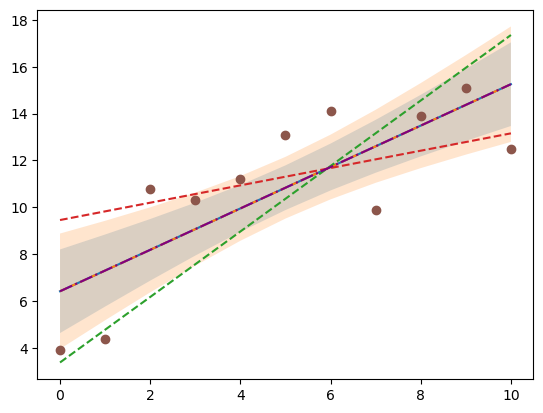

In [ ]:
N = 21
x = np.linspace(0, 10, 11)
y = [3.9, 4.4, 10.8, 10.3, 11.2, 13.1, 14.1,  9.9, 13.9, 15.1, 12.5]

model = sm.OLS(y, sm.add_constant(x)).fit()
intercept, slope = model.params

conf_int = model.conf_int(alpha=0.05)


# fit a linear curve and estimate its y-values and their error.
a, b = np.polyfit(x, y, deg=1)
y_est = a * x + b
y_err = x.std() * np.sqrt(1/len(x) +
                          (x - x.mean())**2 / np.sum((x - x.mean())**2))

fig, ax = plt.subplots()
ax.plot(x, y_est, '-')
ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)
ax.plot(x, y, 'o', color='tab:brown')
ax.plot(x, intercept+slope*x, linestyle='--')
ax.plot(x, conf_int[0,0]+conf_int[1,1]*x, linestyle='--')
ax.plot(x, conf_int[0,1]+conf_int[1,0]*x, linestyle='--')

b_yx, a, r2, CI_alpha_slope, ttt, y_err2 = regress_confidence_sokal_rohlf(x, y, .90)

ax.plot(x, a+b_yx*x, color='purple', linestyle='-.')

ax.fill_between(x, y_est - y_err2, y_est + y_err2, alpha=0.2)
